In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [68]:
x1 = np.random.multivariate_normal([-1, -1], [[1, 0], [0, 1]], size=5)
x2 = np.random.multivariate_normal([+0.5, +0.5], [[1/2, 0], [0, 1/2]], size=5)

In [286]:
x1[0, 0] = x1[0, 0] + 0.2


In [287]:
X = np.concatenate((x1, -x1))


In [288]:
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


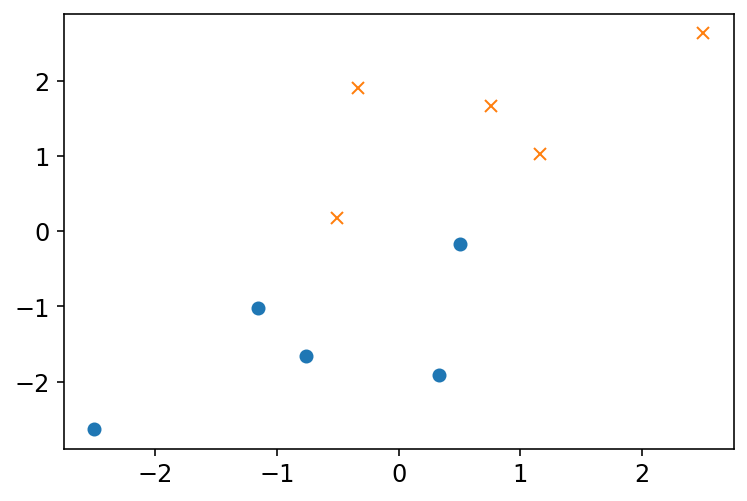

In [289]:
plt.plot(*x1.T, 'o')
plt.plot(*-x1.T, 'x')


In [265]:
from sklearn.linear_model import LogisticRegression


In [318]:
clf = LogisticRegression(solver="lbfgs", penalty='none')
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [319]:
clf.coef_

array([[-10.75027413,  22.97515345]])

In [320]:
clf.intercept_

array([-4.98965643e-07])

In [321]:
X1, X2 = np.meshgrid(np.linspace(-3, 3), np.linspace(-3, 3))
grid = np.c_[X1.ravel(), X2.ravel()]

clf_probas = clf.predict_proba(grid)[:, 1].reshape(X1.shape)


In [322]:
import seaborn as sns


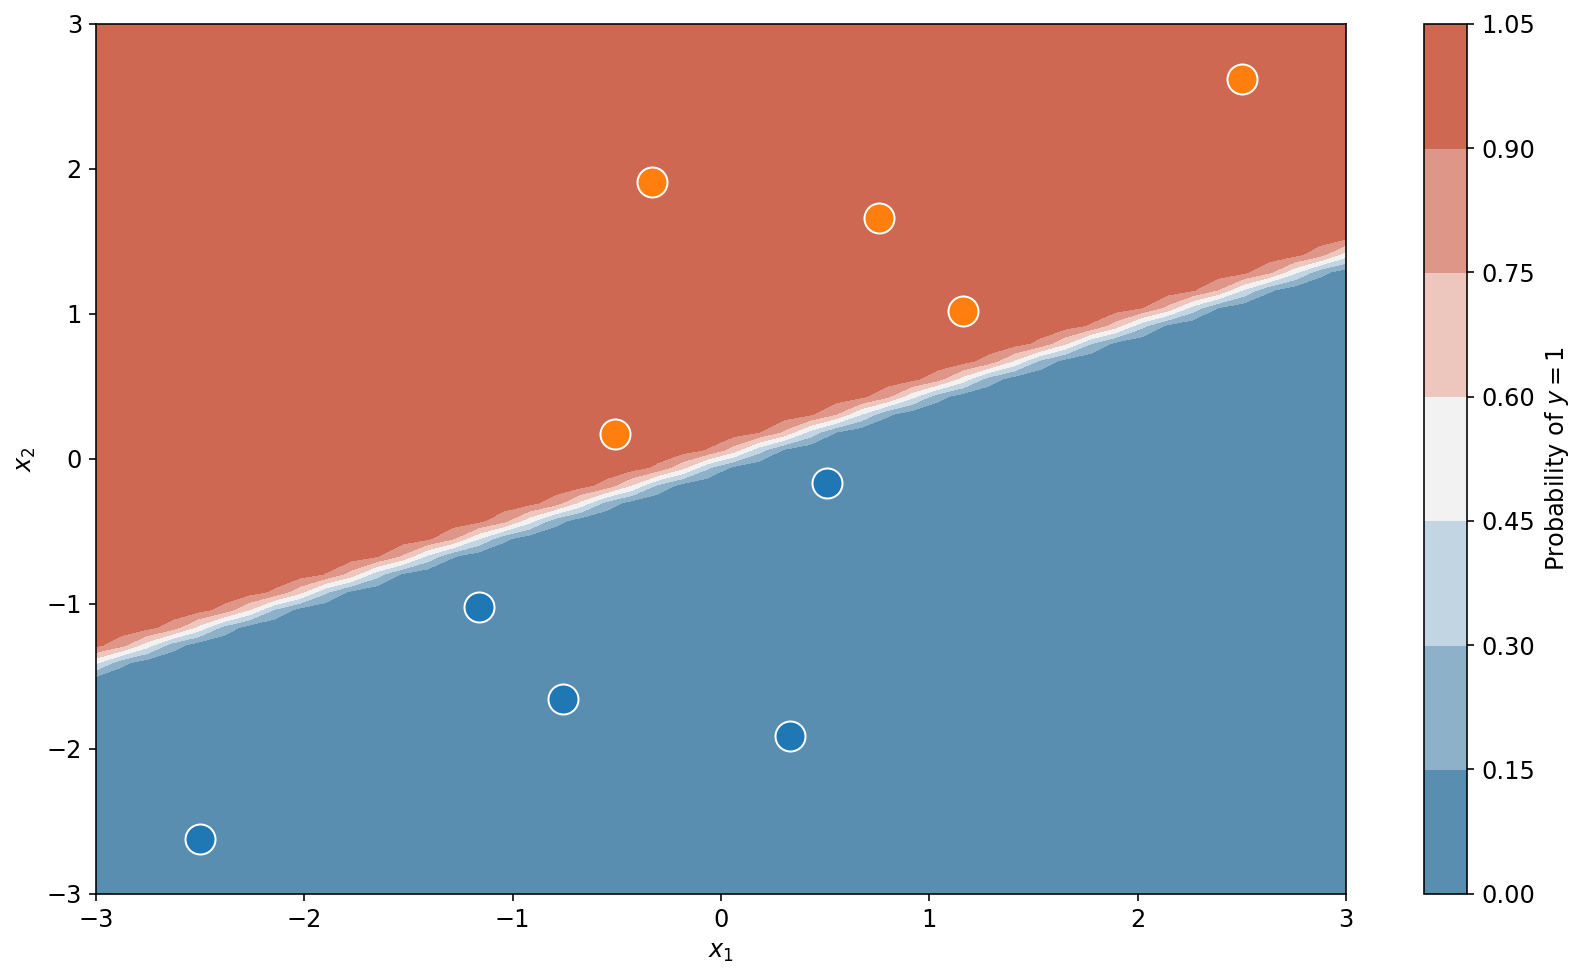

In [323]:
cmap = sns.diverging_palette(237, 18, s=75, l=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(X1, X2, clf_probas, cmap=cmap)
ax.plot(*X[:5].T, 'o', markersize=15, markeredgecolor='white')
ax.plot(*X[5:].T, "o", markersize=15, markeredgecolor='white')
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Probability of $y=1$')
plt.show()


## With regularisation

In [324]:
clf = LogisticRegression(solver="lbfgs", C=10)
clf.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [325]:
clf.coef_

array([[-0.73729648,  3.16552195]])

In [326]:
clf.intercept_

array([-4.24177435e-15])

In [327]:
clf_probas = clf.predict_proba(grid)[:, 1].reshape(X1.shape)

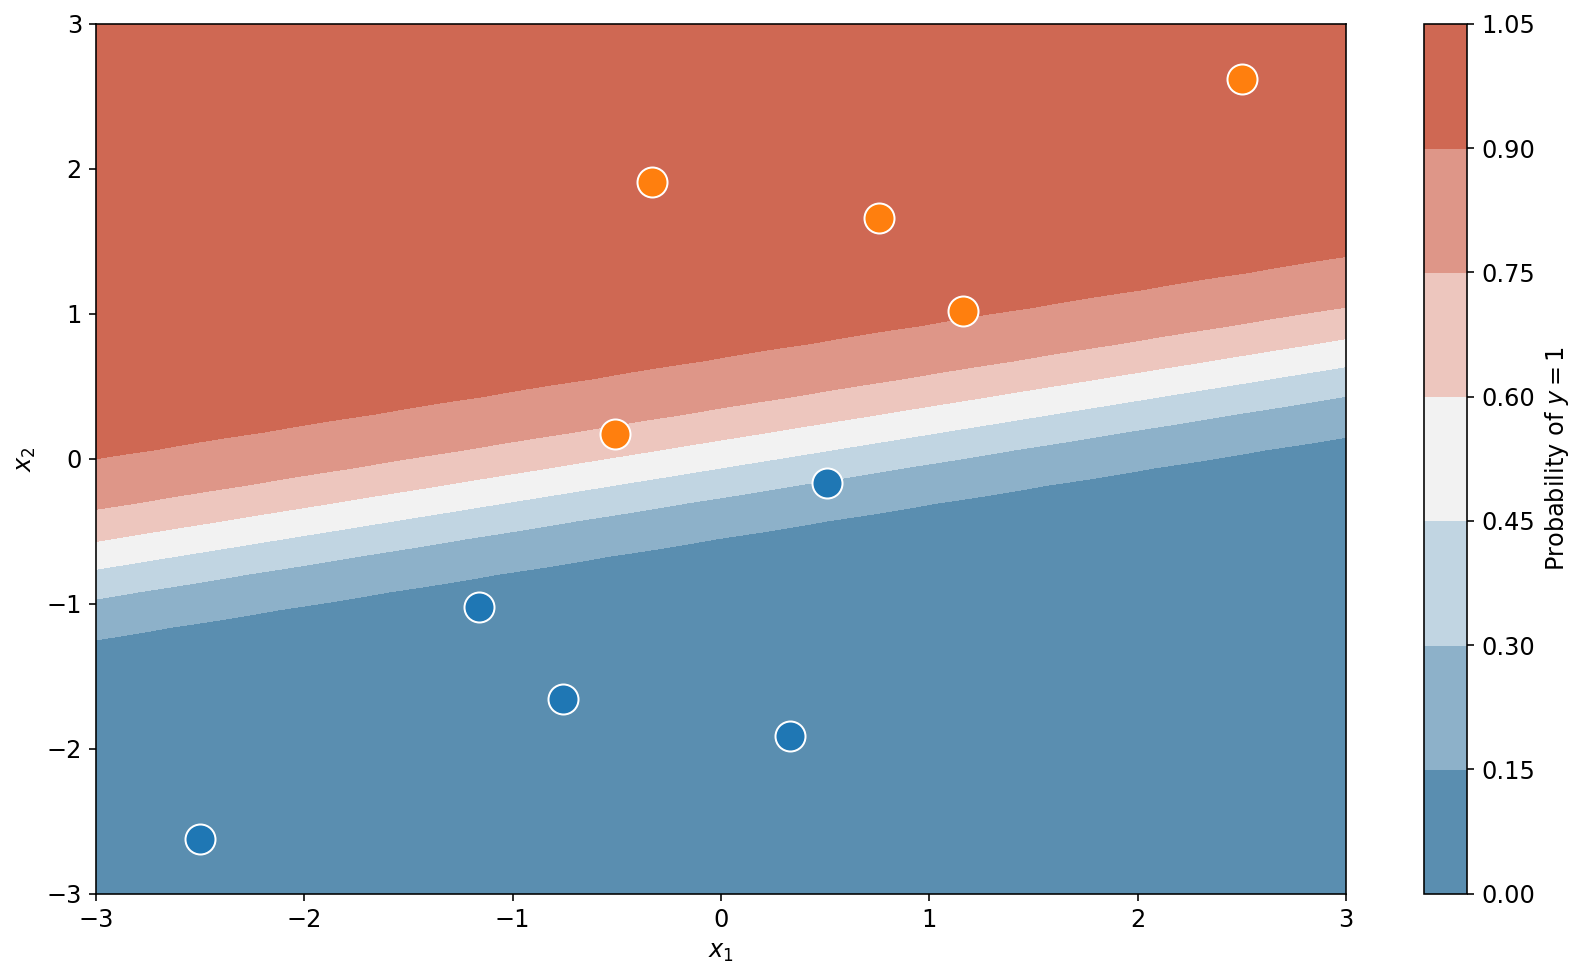

In [328]:
cmap = sns.diverging_palette(237, 18, s=75, l=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(X1, X2, clf_probas, cmap=cmap)
ax.plot(*X[:5].T, 'o', markersize=15, markeredgecolor='white')
ax.plot(*X[5:].T, "o", markersize=15, markeredgecolor='white')
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Probability of $y=1$')
plt.show()


In [202]:
import pystan

In [209]:
logistic_regression_code = """
data {
    int N;
    int D;
    matrix[N, D] X;
    int y[N];
}

parameters {
    vector[D] beta;
}

model {
    beta ~ normal(0, sqrt(10));
    y ~ bernoulli_logit(X*beta);
}
"""

In [210]:
bayes_logistic_regression = pystan.StanModel(model_code=logistic_regression_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46a75f2b4d9aacb86289829671edd83a NOW.


In [329]:
data = {
    "N": X.shape[0],
    "D": X.shape[1],
    "X": X,
    "y": y,
}

In [330]:
samples = bayes_logistic_regression.sampling(data=data)

In [331]:
samples

Inference for Stan model: anon_model_46a75f2b4d9aacb86289829671edd83a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]  -0.48    0.04   1.82  -4.11  -1.67  -0.53   0.67   3.27   1830    1.0
beta[2]   4.31    0.05   1.96   1.11   2.86   4.12   5.55   8.62   1417    1.0
lp__     -2.44    0.03   1.02  -5.12  -2.86  -2.11   -1.7  -1.43   1027    1.0

Samples were drawn using NUTS at Tue May 26 07:45:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [332]:
beta_samples = samples.extract()['beta']

In [311]:
from mpl_toolkits.mplot3d import Axes3D

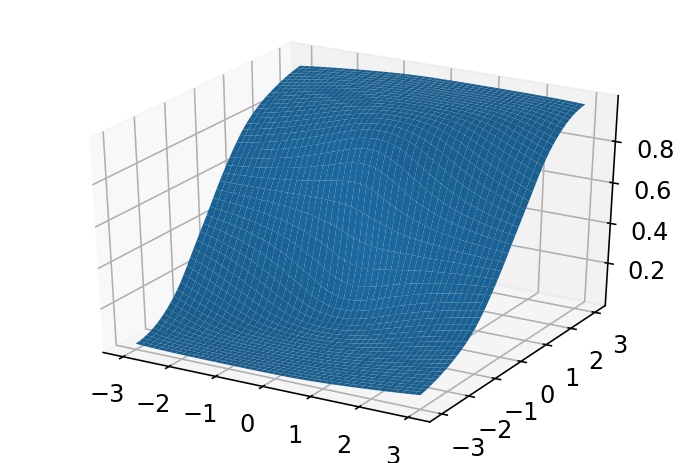

In [312]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, probas)

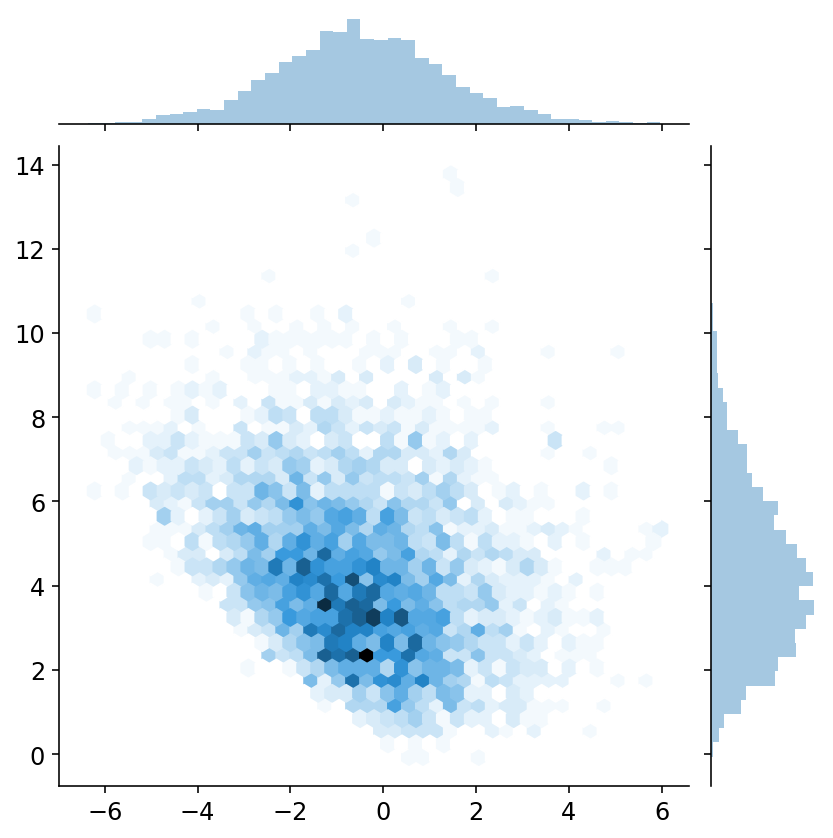

In [333]:
sns.jointplot(*beta_samples.T, kind='hex')

In [334]:
def logistic(x):
    """Inverse of the logit function."""
    return 1 / (1 + np.exp(-x))

In [335]:
n = 500
weights = beta_samples[:n]
probas = logistic(grid @ weights.T).mean(axis=1).reshape(X1.shape)

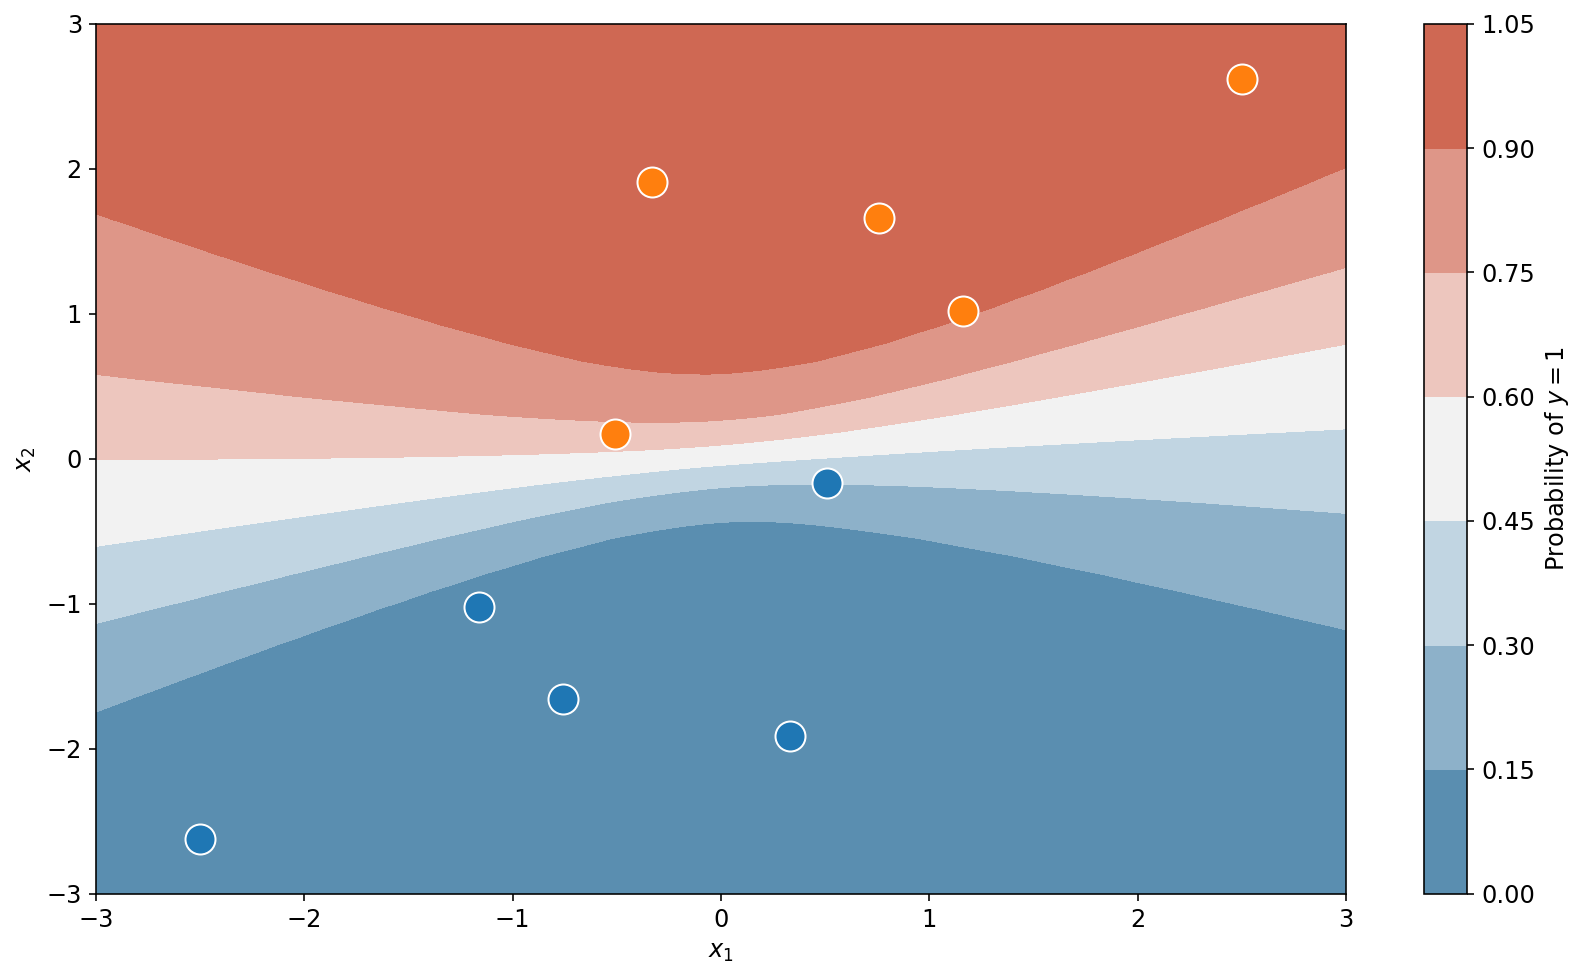

In [336]:
cmap = sns.diverging_palette(237, 18, s=75, l=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(X1, X2, probas, cmap=cmap)
ax.plot(*X[:5].T, 'o', markersize=15, markeredgecolor='white')
ax.plot(*X[5:].T, "o", markersize=15, markeredgecolor='white')
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Probability of $y=1$')
plt.show()


In [337]:
uncertainty = logistic(grid @ weights.T).std(axis=1).reshape(X1.shape)

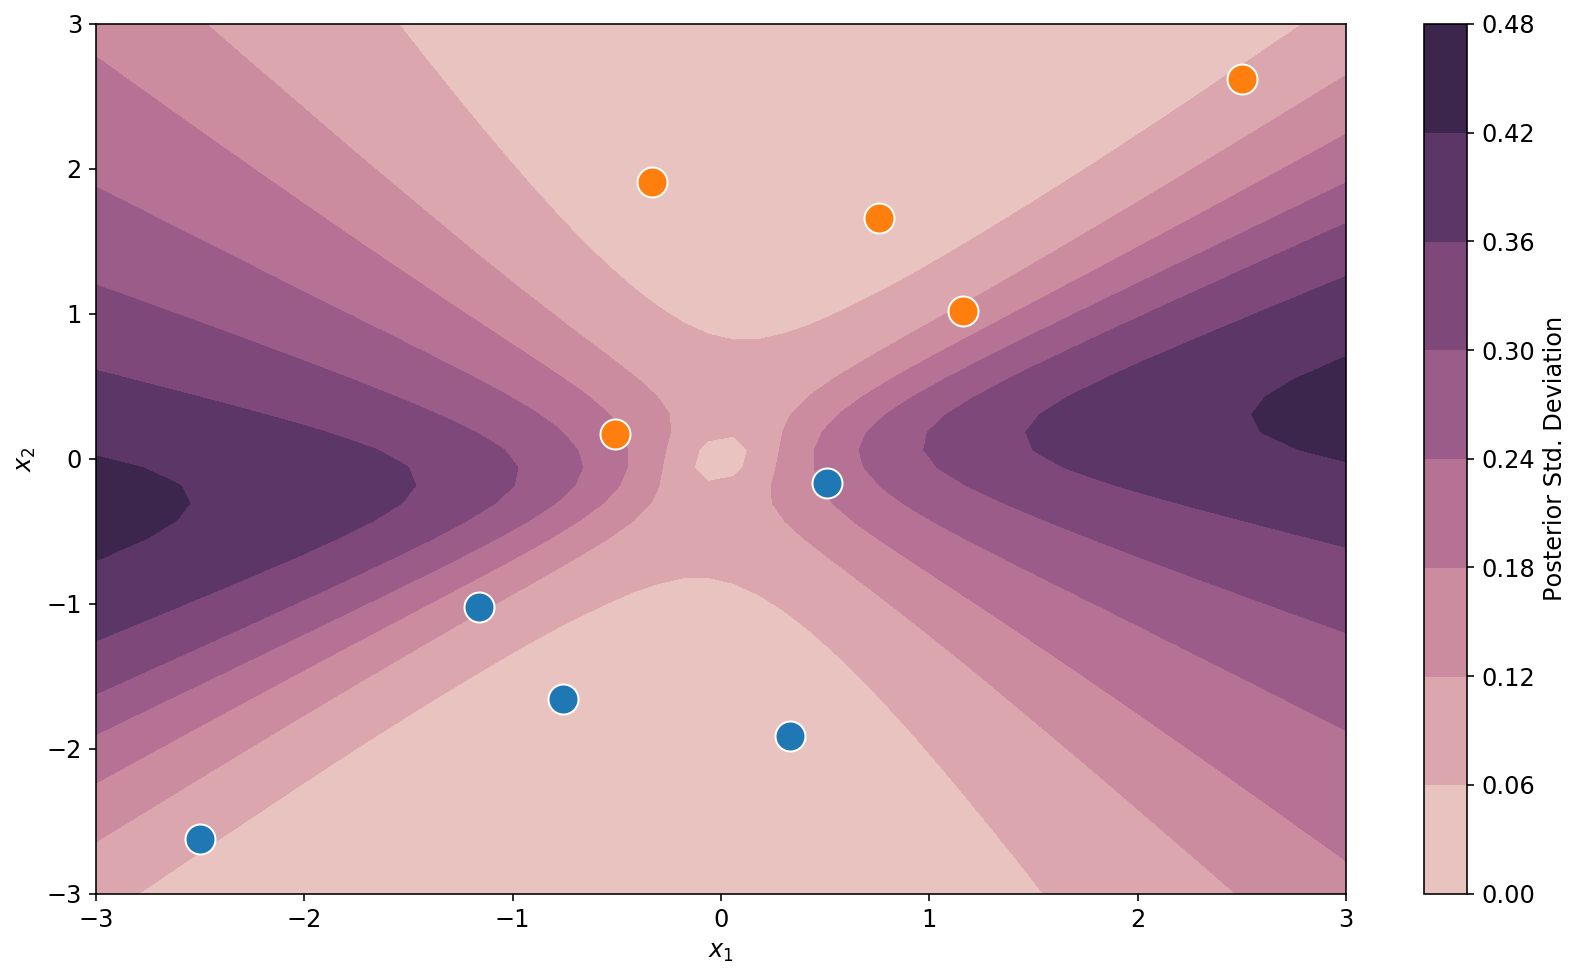

In [339]:
cmap = sns.cubehelix_palette(n_colors=3, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(X1, X2, uncertainty, cmap=cmap)
ax.plot(*X[:5].T, 'o', markersize=15, markeredgecolor='white')
ax.plot(*X[5:].T, "o", markersize=15, markeredgecolor='white')
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel("Posterior Std. Deviation")
plt.show()


In [316]:
X = X.round(2)

In [317]:
X

array([[ 0.51, -0.17],
       [-1.16, -1.02],
       [ 0.33, -1.91],
       [-0.76, -1.66],
       [-2.5 , -2.62],
       [-0.51,  0.17],
       [ 1.16,  1.02],
       [-0.33,  1.91],
       [ 0.76,  1.66],
       [ 2.5 ,  2.62]])

# Animation

In [341]:
# Animation
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = "/Users/omarfsosa/anaconda3/envs/stan/bin/ffmpeg"

In [343]:
n = 300
weights = beta_samples[:n]
probas = logistic(grid @ weights.T).mean(axis=1).reshape(X1.shape)
# contour = axes[0].contourf(X1, X2, probas, cmap=cmap)

In [346]:
mode = bayes_logistic_regression.optimizing(data=data)['beta']

/Users/omarfsosa/anaconda3/envs/stan/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'axes'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


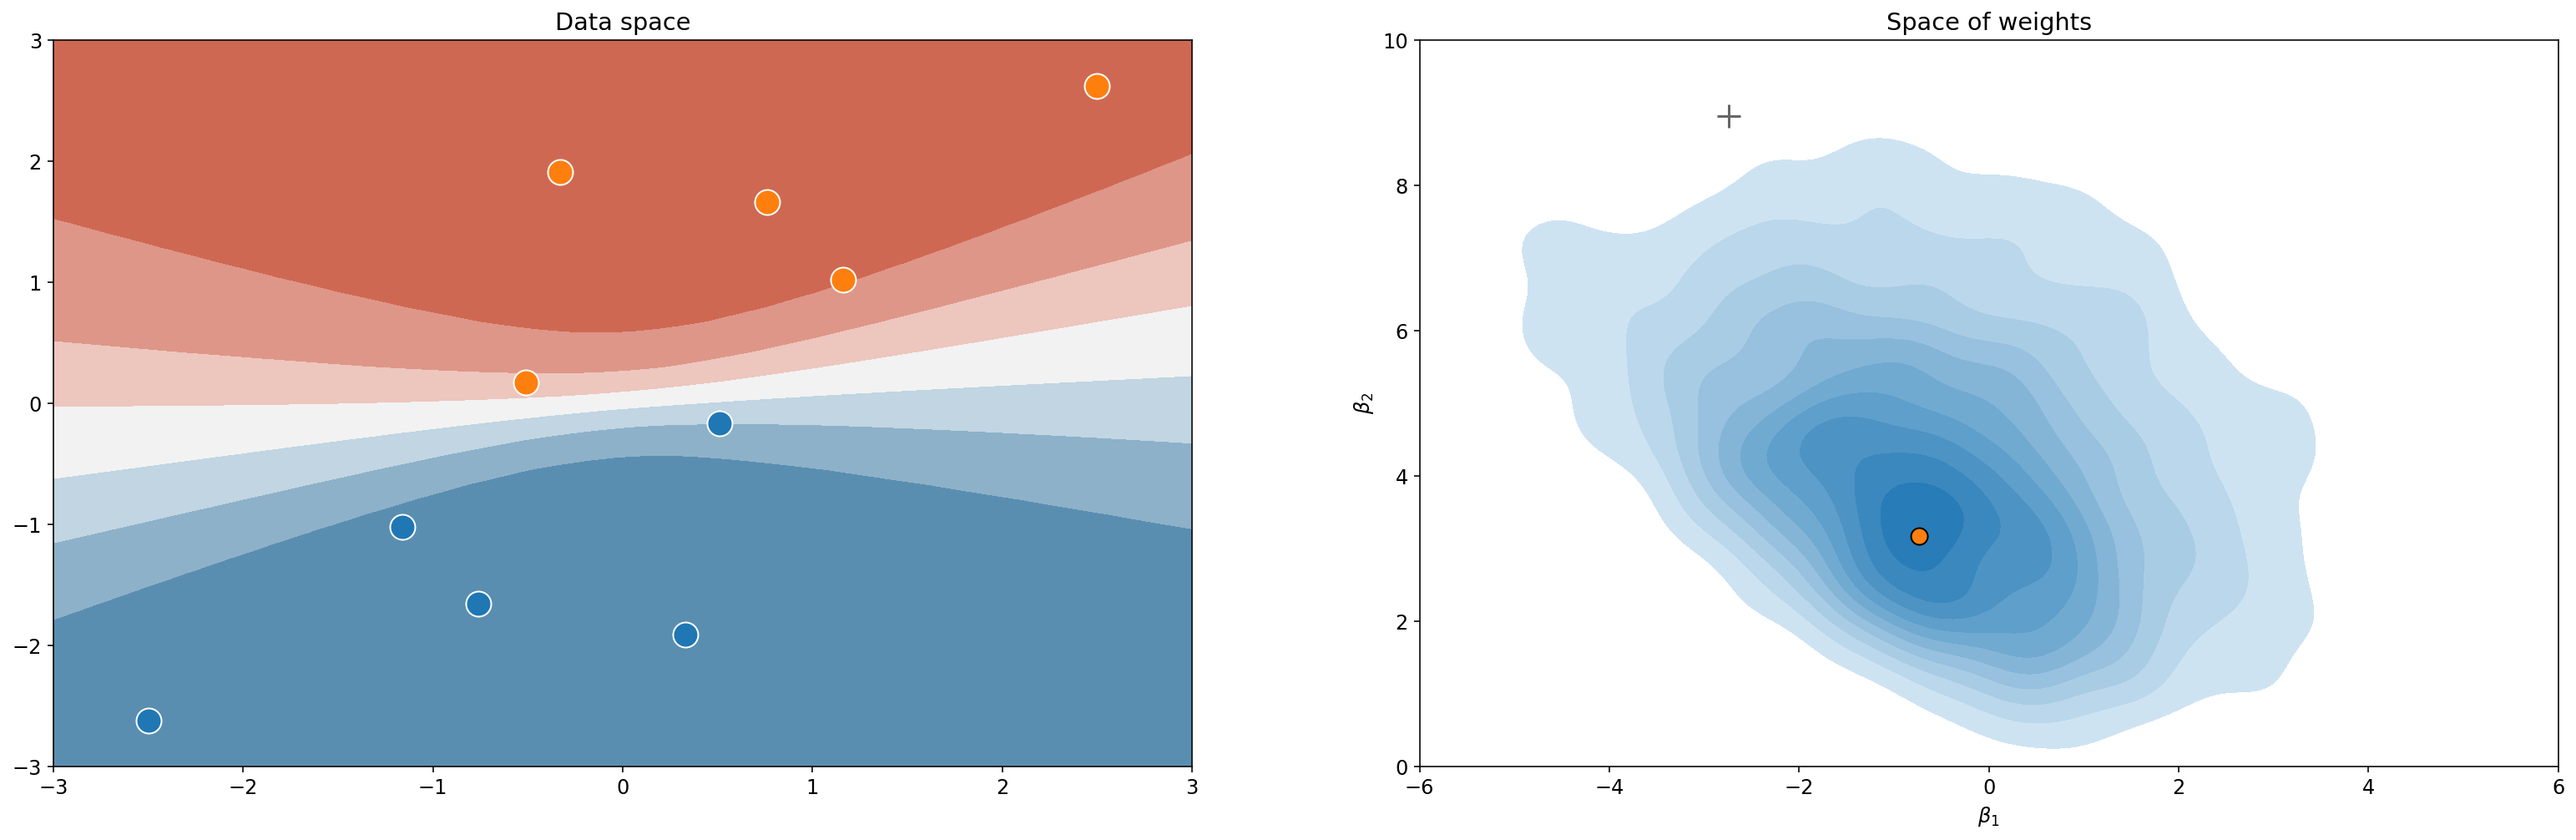

In [364]:
fig, axes = plt.subplots(1, 2, figsize=(1 + 2 *8 * 1.618, 8))
cmap = sns.diverging_palette(237, 18, s=75, l=50, as_cmap=True)
contour = axes[0].contourf(X1, X2, probas, cmap=cmap)

# Data Space
axes[0].plot(*X[:5].T, 'o', markersize=15, markeredgecolor='white', zorder=1)
axes[0].plot(*X[5:].T, "o", markersize=15, markeredgecolor='white', zorder=1)
axes[0].set_xlim([-3, 3])
axes[0].set_ylim([-3, 3])
axes[0].set_title("Data space")

#
# Weights space
axes[1].set_xlabel("$\\beta_1$")
axes[1].set_ylabel("$\\beta_2$")
axes[1].set_ylim([0, 10])
axes[1].set_xlim([-6, 6])
axes[1].set_title("Space of weights")
sns.kdeplot(*beta_samples.T, shade=True, shade_lowest=False, gridsize=200, vertical=True, cbar=False, axes=axes[1])
axes[1].scatter(*mode, label="Mode", marker="o", s=100, c='C1', edgecolors="k")

## Plot samples in weight space
n_sample = 1
plot_samples = axes[1].scatter(*beta_samples[:n_sample].T, s=200, alpha=0.6, marker="+", color='k')

In [ ]:
# fig.savefig(f"/Users/omarfsosa/Documents/Projects/bayesian-statistics/resources/animation_sampling_{n}.pdf", bbox_inches="tight")

In [365]:
def init():
#     samples.set_offsets(np.c_[None])
    plot_samples.set_offsets(beta_samples[:n_sample + 1])
    weights = beta_samples[n_sample]
    probas = logistic(grid @ weights).reshape(X1.shape)
    contour.set_array(np.c_[X1, X2, probas])
    return (samples, contour)


# animation function. This is called sequentially
def animate(i):
    plot_samples.set_offsets(beta_samples[:n_sample + i])
    weights = beta_samples[n_sample + i - 1]
    probas = logistic(grid @ weights).reshape(X1.shape)

    contour = axes[0].contourf(X1, X2, probas, cmap=cmap)
    # Point A
#     axes[0].scatter(0.84, 0.54, marker="o", s=300, c='w', edgecolors="k")
# #     axes[0].annotate("A", (0.84, 0.54), xytext=(0.86, 0.56), color='w', size=20)

#     # Point B
#     axes[0].scatter(0.1, 0.6, marker="o", s=300, c='w', edgecolors="k")
# #     axes[0].annotate("B", (0.1, 0.6), xytext=(0.12, 0.62), color='w', size=20)


#     axes[0].plot(*X[:5].T, 'o', markersize=15, markeredgecolor='white')
#     axes[0].plot(*X[5:].T, "o", markersize=15, markeredgecolor='white')
#     axes[0].set_xlim([-3, 3])
#     axes[0].set_ylim([-3, 3])
#     axes[0].set_title("Data space")

    return (samples, contour)

In [366]:
anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=np.arange(0, 100),
    interval=250,
#     blit=True
)

In [367]:
HTML(anim.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size (inches) has been adjusted from 26.888 x 8.0 to 26.86111111111111 x 8.0
INFO:matplotlib.animation:MovieWriter.run: running command: ['/Users/omarfsosa/anaconda3/envs/stan/bin/ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1934x576', '-pix_fmt', 'rgba', '-r', '4.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/ck/bscr5ntx7qb7jy7v_wv9n1d00000gn/T/tmp664k776t/temp.m4v']


In [ ]:
HTML(anim.to_html5_video())

anim.save(filename="./sampling_animation_contour.mp4", writer=animation.FFMpegWriter(), dpi=500)